In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')
import lsst.daf.persistence as daf_persistence
import lsst.afw.geom as afwGeom
from lsst.afw.geom import Angle
import lsst.geom
from scipy import ndimage
import lsst.afw.image as afwImage

In [2]:
from lsst.pipe.tasks.scaleZeroPoint import ScaleZeroPointTask, ScaleZeroPointConfig

In [3]:
from lsst.ip.diffim.dcrModel import calculateImageParallacticAngle, applyDcr, calculateDcr

In [22]:
def _calculateImageOffset(template, exposure, dcrNumSubfilters,
                          convergenceMaskPlanes, badMaskPlanes, parAng=None, removeMeanDcr=True):
    visitInfo = exposure.getInfo().getVisitInfo()
    wcs = exposure.getInfo().getWcs()
    if removeMeanDcr:
        dcr = calculateDcr(visitInfo, wcs, exposure.getFilter(), dcrNumSubfilters)
        dcrAvgShift = tuple(np.mean(dcr, axis=0))
        print(dcrAvgShift)
    else:
        dcrAvgShift = (0., 0.)
    if parAng is None:
        parAng = calculateImageParallacticAngle(visitInfo, wcs)

    convergeMask = template.mask.getPlaneBitMask(convergenceMaskPlanes)
    badMask = template.mask.getPlaneBitMask(badMaskPlanes)
    isGood = ((template.mask.array | exposure.mask.array) & badMask) == 0
    isDetected = ((template.mask.array & exposure.mask.array) & convergeMask) > 0
    fftRef = _rotateAndFFT(template.image.array, parAng, isDetected, isGood)
    fftImage = _rotateAndFFT(exposure.image.array, parAng, isDetected, isGood)

    nbin = fftImage.shape[1]
    shift_1d_fft = np.zeros(nbin, dtype=complex)
    for j in range(nbin):
        mr, b = np.polyfit(np.real(fftImage[j, :]), np.real(fftRef[j, :]), 1)
        mi, b = np.polyfit(np.imag(fftImage[j, :]), np.imag(fftRef[j, :]), 1)
        shift_1d_fft[j] = mr + complex(0, 1)*mi
    shift_1d = np.fft.ifft(shift_1d_fft)
    xvals = np.arange(nbin) - nbin/2
    yvals = np.real(np.fft.fftshift(shift_1d))
    offsetAmplitude = np.sum(yvals*xvals)/np.sum(yvals)
    shiftX = offsetAmplitude*np.sin(parAng.asRadians())
    shiftY = offsetAmplitude*np.cos(parAng.asRadians())
    print((shiftY, shiftX))
    offset = (shiftY - dcrAvgShift[0], shiftX - dcrAvgShift[1])
    return offset

In [23]:
seed = 6

In [6]:
base_directory = "/Users/sullivan/LSST/simulations/test%1i_quasars/" % seed

In [7]:
repository = base_directory + 'input_data/rerun/processed_data/rerun/compareWarp/'
butler = daf_persistence.Butler(repository)

In [8]:
deepDataId={'tract':0,'patch':'1,1','filter':'g'}

In [9]:
templateCoadd = butler.get("deepCoadd", dataId=deepDataId)

In [10]:
expDataId={'tract':0,'patch':'1,1','filter':'g', 'visit':104}

In [11]:
exposure = butler.get("deepCoadd_directWarp", dataId=expDataId)
zp_config = ScaleZeroPointConfig()
zp_scale = ScaleZeroPointTask(config=zp_config)
imageScaler = zp_scale.computeImageScaler(exposure)
imageScaler.scaleMaskedImage(exposure.maskedImage)

<IPython.core.display.Javascript object>


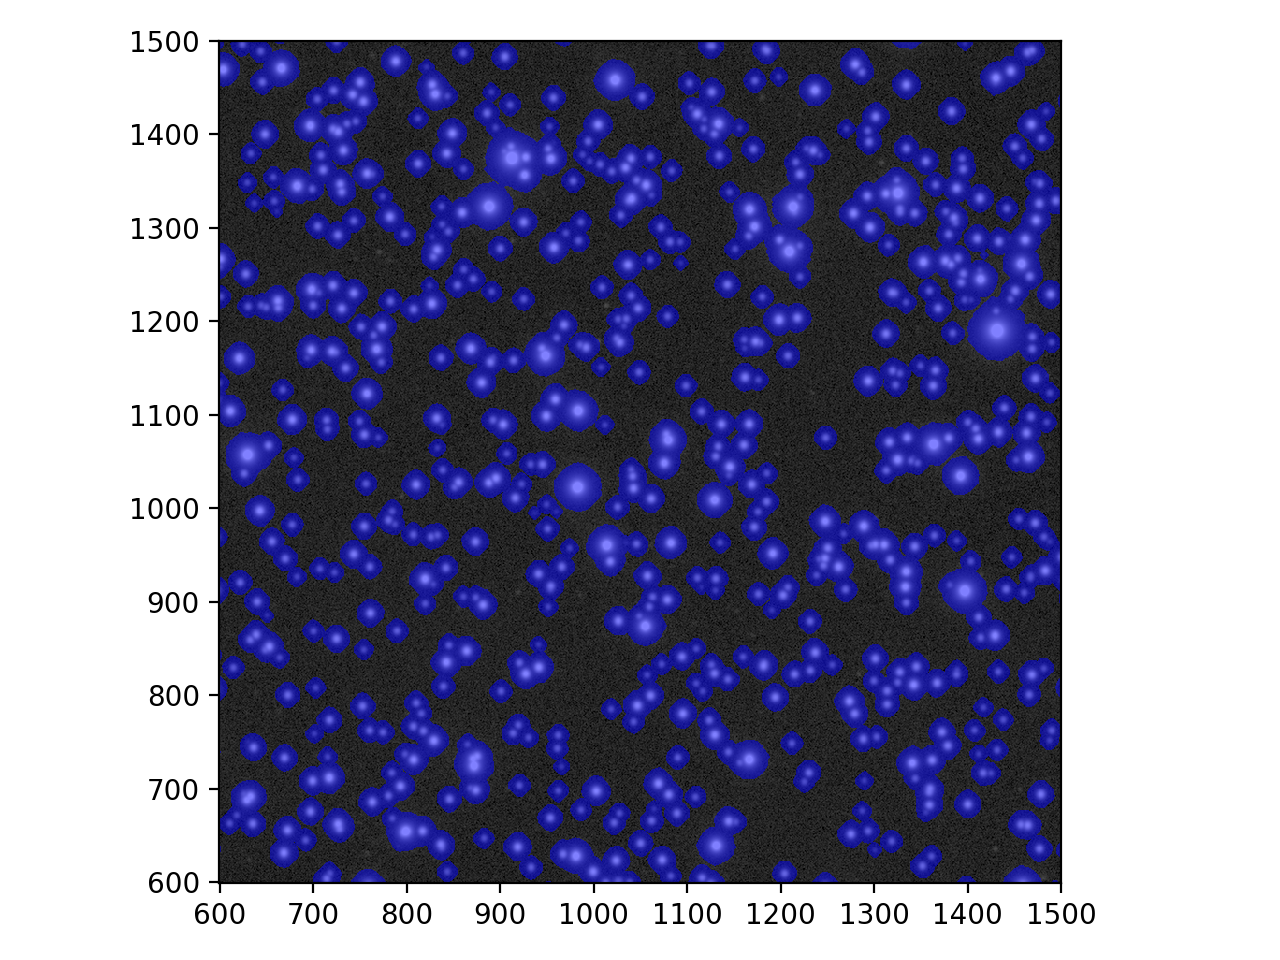

In [24]:
disp1 = afwDisplay.Display(1)
disp1.setMaskTransparency(50)
disp1.scale('asinh', 'zscale', Q=8)
disp1.mtv(templateCoadd)

<IPython.core.display.Javascript object>


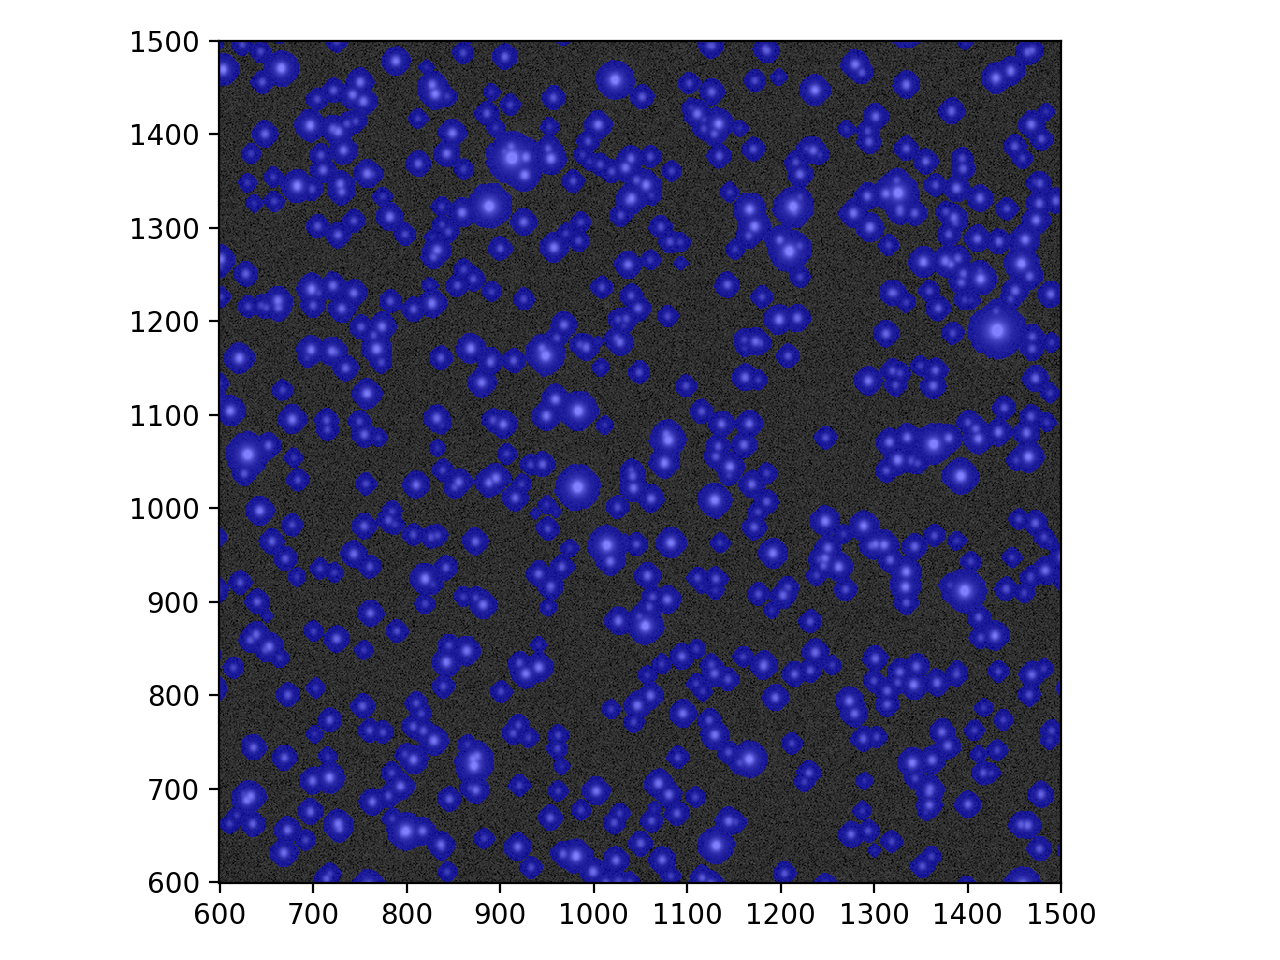

In [25]:
disp1 = afwDisplay.Display(2)
disp1.setMaskTransparency(50)
disp1.scale('asinh', 'zscale', Q=8)
disp1.mtv(exposure)

In [26]:
visitInfo = exposure.getInfo().getVisitInfo()
wcs = exposure.getInfo().getWcs()
parAng = calculateImageParallacticAngle(visitInfo, wcs)
print(parAng.asDegrees())

0.0


In [58]:
dcr = calculateDcr(visitInfo, wcs, exposure.getFilter(), 3, splitSubfilters=True)
dcrAvgShift = np.mean(np.mean(dcr, axis=0), axis=0)

In [59]:
offset = np.mean(np.mean(dcr, axis=0), axis=0)/2.
dcrShift = [tuple([tuple(shift - offset) for shift in split]) for split in dcr]

In [60]:
dcr

[((1.6167432728159374, 0.0), (0.8822817038176165, 0.0)),
 ((0.25532696251433795, 0.0), (-0.2641209510938983, -0.0)),
 ((-0.7146440702419496, -0.0), (-1.096242394929816, -0.0))]

In [61]:
offset

array([0.05661204, 0.        ])

In [62]:
dcrShift

[((1.5601312292424185, 0.0), (0.8256696602440975, 0.0)),
 ((0.19871491894081894, 0.0), (-0.32073299466741734, -0.0)),
 ((-0.7712561138154687, -0.0), (-1.1528544385033348, -0.0))]

In [50]:
dcrAvgShift

array([0.11322409, 0.        ])

In [43]:
testShift = (2.3, 4.5)

In [51]:
testShift - dcrAvgShift

array([2.18677591, 4.5       ])

In [31]:
ref = templateCoadd.image.clone()
img = exposure.image.clone()
ref_mask = templateCoadd.mask
img_mask = exposure.mask
ref_detected = (ref_mask.array & ref_mask.getPlaneBitMask("DETECTED")) > 0
img_detected = (img_mask.array & img_mask.getPlaneBitMask("DETECTED")) > 0
detected = ref_detected & img_detected

In [32]:
badMaskPlanes = ["EDGE", "CR", "NO_DATA"]
ref_good = (ref_mask.array & ref_mask.getPlaneBitMask(badMaskPlanes)) == 0
img_good = (img_mask.array & img_mask.getPlaneBitMask(badMaskPlanes)) == 0

In [33]:
pix_use = (ref_detected & img_detected) & (ref_good & img_good)
print(np.sum(pix_use))

296614


In [34]:
goodPix = ((ref_mask.array | img_mask.array) & ref_mask.getPlaneBitMask(badMaskPlanes)) == 0
detectPix = ((ref_mask.array & img_mask.array) & ref_mask.getPlaneBitMask("DETECTED")) > 0
pix_use2 = goodPix & detectPix

In [35]:
print(np.sum(pix_use2))
print(np.sum(pix_use2 != pix_use))

296614
0


In [36]:
ref_noise = np.std(ref.array[~ref_detected & ref_good])
img_noise = np.std(img.array[~img_detected & img_good])

In [365]:
ref2 = np.zeros_like(ref.array) + ref_noise*np.random.standard_normal(ref.array.shape)
ref2[pix_use] = ref.array[pix_use]
ref_rot = ndimage.rotate(ref2, -parAng.asDegrees(), reshape=False, mode='constant', cval=ref_noise)
img2 = np.zeros_like(img.array) + img_noise*np.random.standard_normal(img.array.shape)
img2[pix_use] = img.array[pix_use]
img_rot = ndimage.rotate(img2, -parAng.asDegrees(), reshape=False, mode='constant', cval=img_noise)

In [366]:
ref_fft = np.fft.fft2(ref_rot)
img_fft = np.fft.fft2(img_rot)

<IPython.core.display.Javascript object>


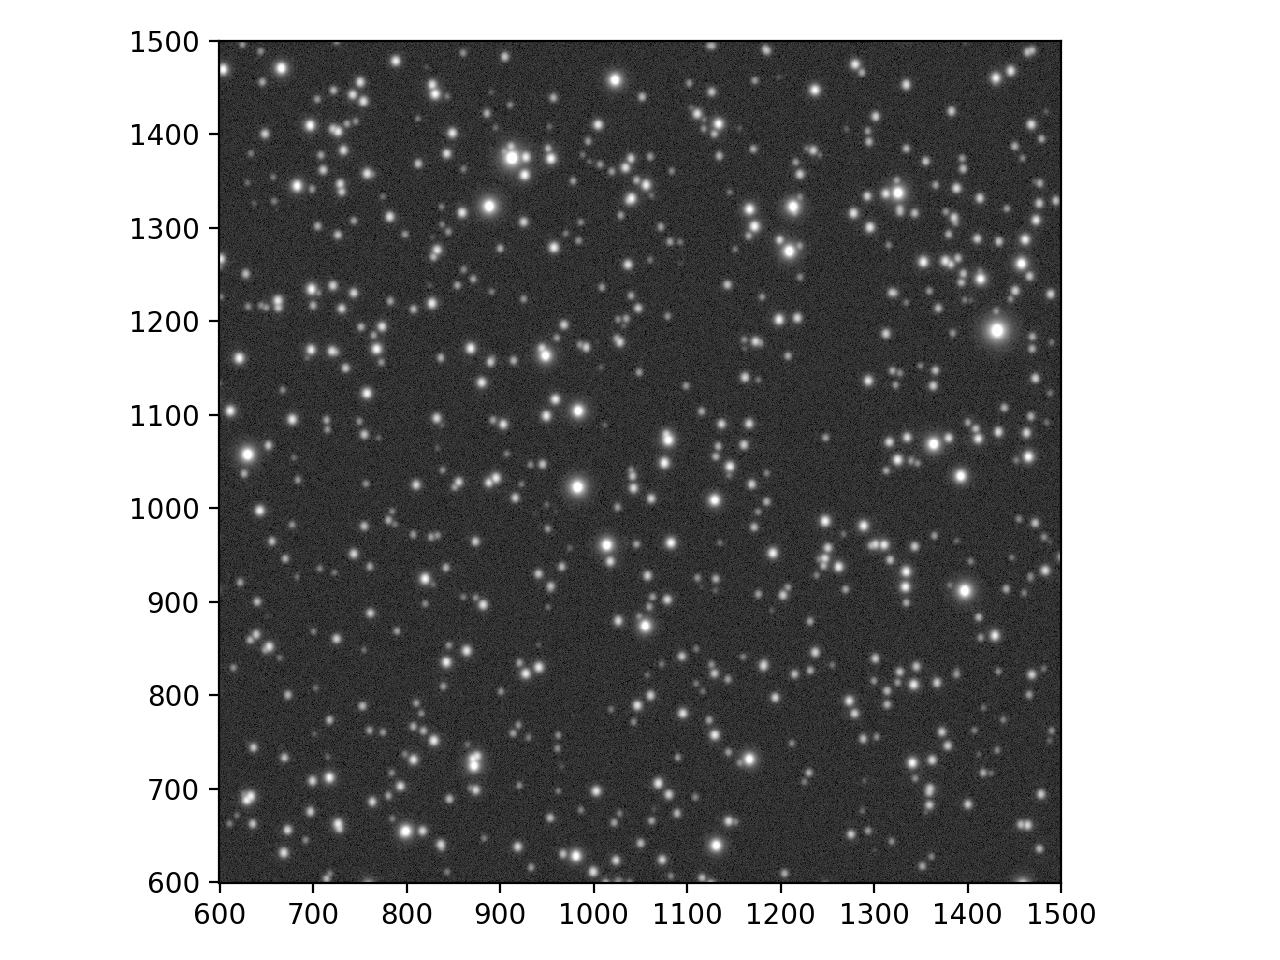

In [367]:
disp1 = afwDisplay.Display(4)
img_disp = ref.clone()
img_disp.array[:, :] = img_rot
disp1.scale('asinh', 'zscale', Q=8)
disp1.mtv(img_disp)

<IPython.core.display.Javascript object>


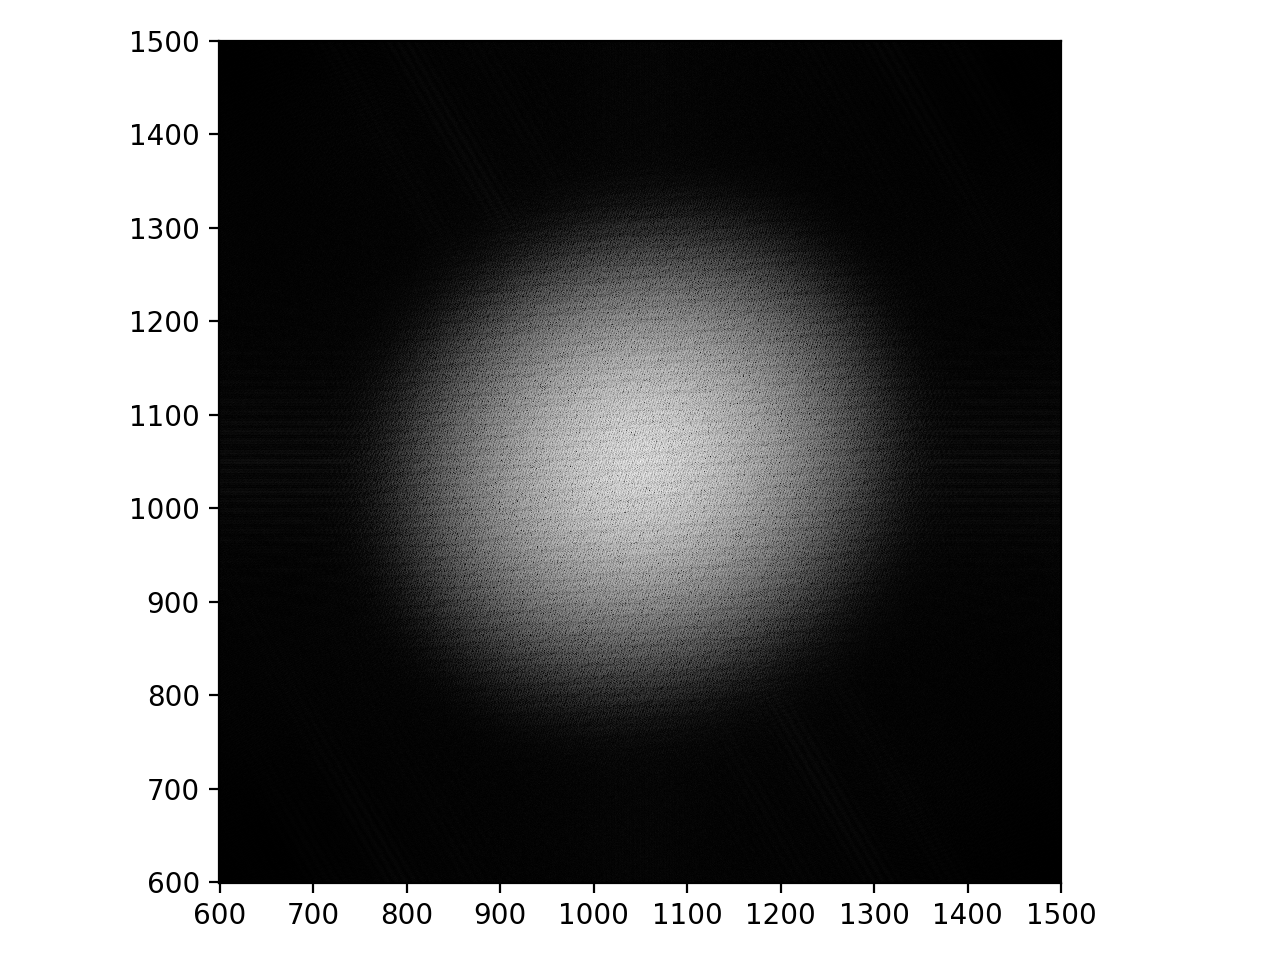

In [359]:
disp1 = afwDisplay.Display(5)
img_disp = img.clone()
img_disp.array[:, :] = np.fft.fftshift((np.abs(img_fft)+np.abs(ref_fft))/2.)
disp1.scale('asinh', 'zscale', Q=8)
disp1.mtv(img_disp)

In [368]:
weight = (np.abs(img_fft)+np.abs(ref_fft))/2.

In [369]:
ref_fft_weighted = ref_fft*weight
img_fft_weighted = img_fft*weight

In [370]:
nbin = img_fft_weighted.shape[1]
shift_1d_fft = np.zeros(nbin, dtype=complex)
for j in range(nbin):
    mr,b = np.polyfit(np.real(img_fft[j, :]), np.real(ref_fft[j, :]), 1)
    mi,b = np.polyfit(np.imag(img_fft[j, :]), np.imag(ref_fft[j, :]), 1)
    shift_1d_fft[j] = mr + complex(0, 1)*mi
shift_1d = np.fft.ifft(shift_1d_fft)

In [371]:
ndimage.measurements.center_of_mass(np.real(np.fft.fftshift(shift_1d)))

(450.19897707262,)

In [372]:
xvals = np.arange(900) - 450.
yvals = np.real(np.fft.fftshift(shift_1d))
np.sum(yvals*xvals)/np.sum(yvals)

0.19897707261994899

<IPython.core.display.Javascript object>


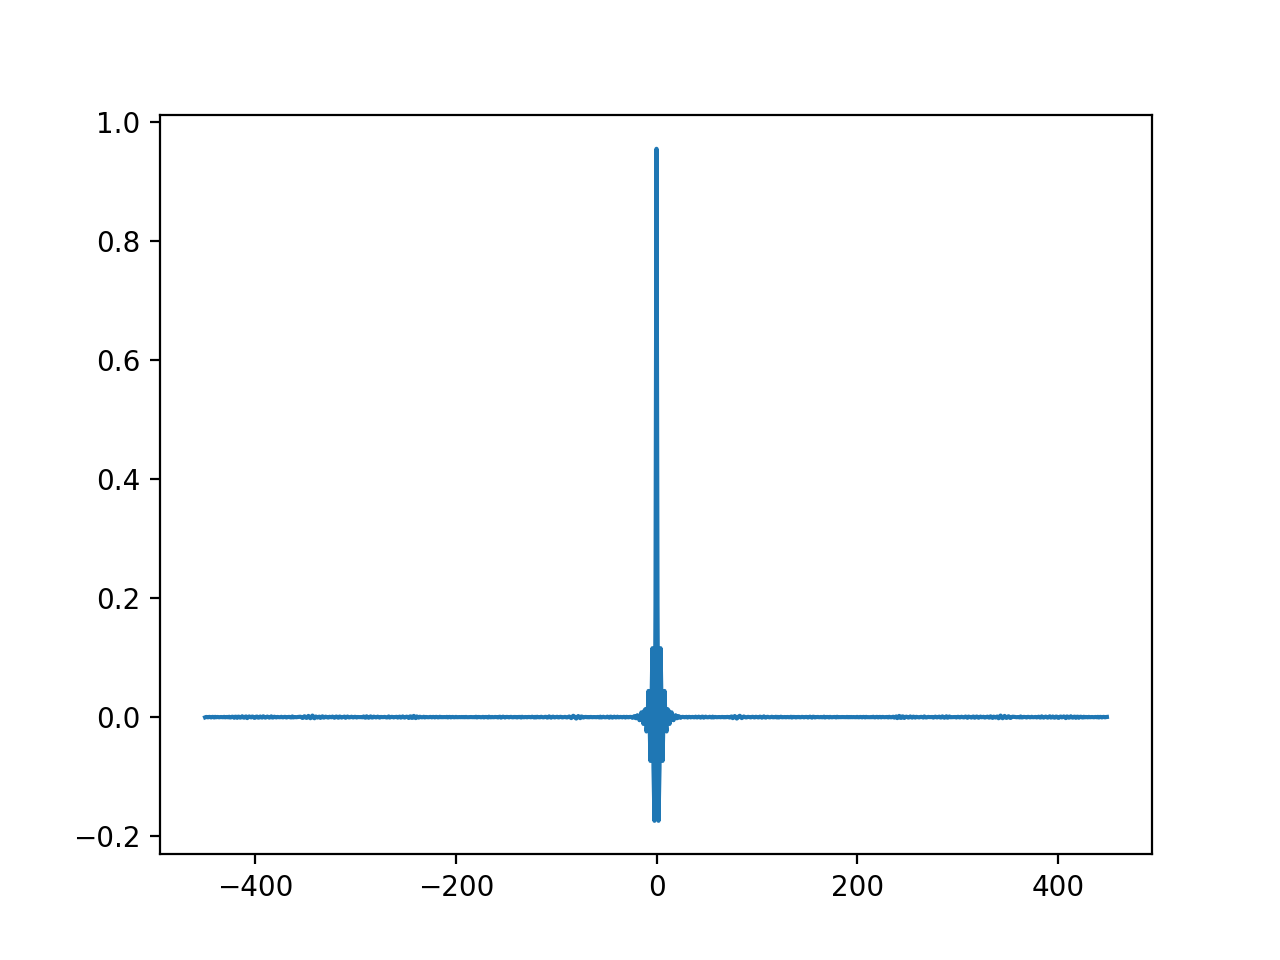

In [373]:
afwDisplay.Display(6)
plt.plot(xvals,np.real(np.fft.fftshift(shift_1d)))

In [108]:
a = np.arange(5)

In [326]:
a.shape

(5,)

<IPython.core.display.Javascript object>


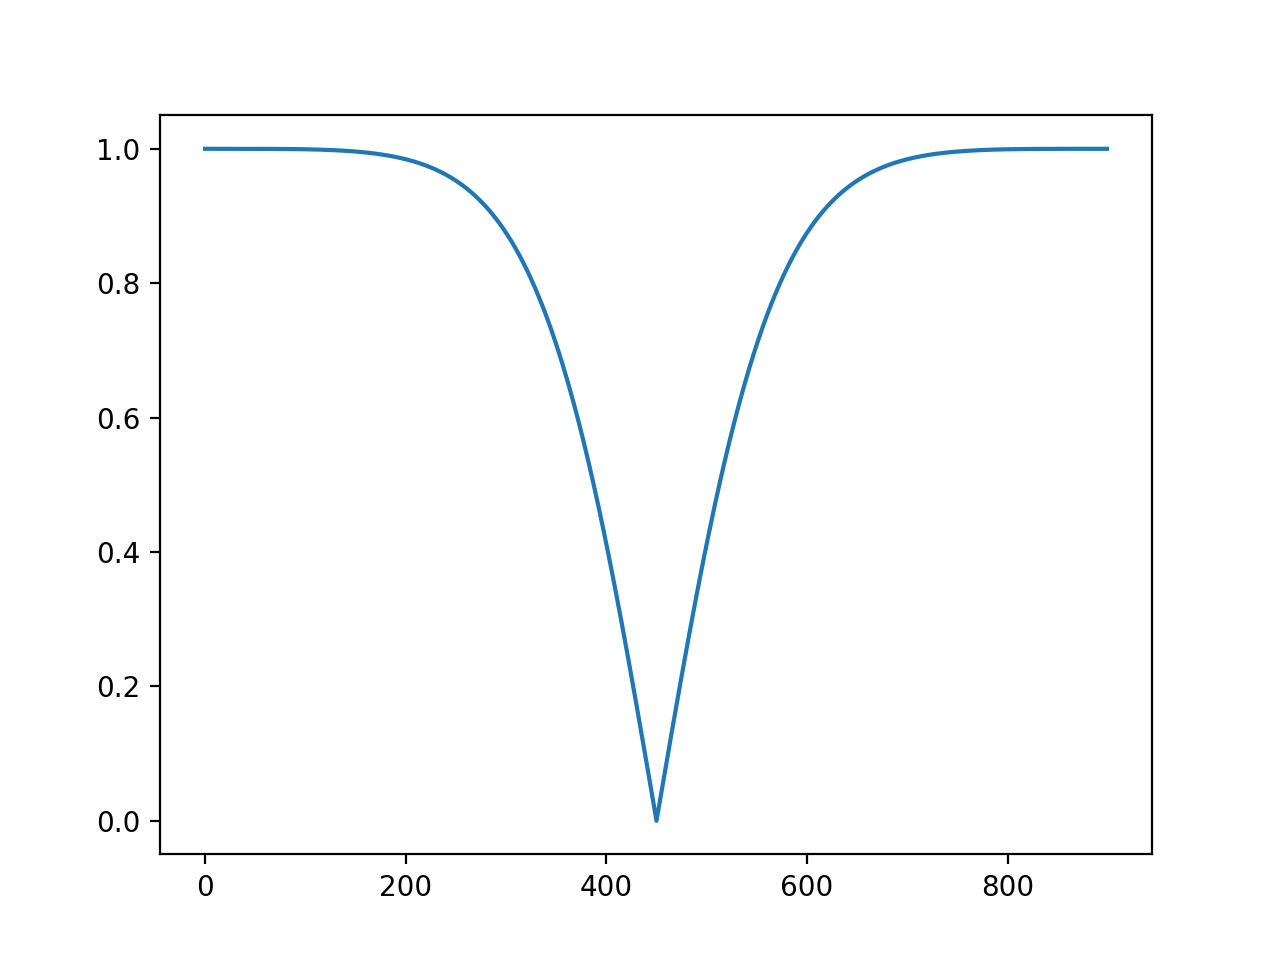

In [327]:
shift_test = base_shift_image.clone().array
weight_test = np.ones_like(shift_test)

shift_test_1d = np.sum(shift_test, axis=1)/np.sum(weight_test, axis=1)
afwDisplay.Display(7)
plt.plot(shift_test_1d)

In [328]:
shift_test_1d[0]

1.0000001

In [73]:
a = np.zeros_like(a)

In [78]:
a_real = np.zeros_like(np.real(a))
a_real += 1
a_imag = np.zeros_like(np.real(a))
a_imag += 1.2

In [79]:
a += a_real + complex(0,1)*a_imag

In [80]:
a

array(1.+1.2j)

In [64]:
diffim2 = np.zeros_like(diffim.image.array) + noiseCutoff
diffim2[usePixels] = diffim.image.array[usePixels]
rotImg = ndimage.rotate(diffim2, -parAng, reshape=True, mode='constant', cval=noiseCutoff)
